# Part 2

https://www.youtube.com/watch?v=TCH_1BHY58I

In [231]:
import torch
import torch.nn.functional as F
# print the loss values
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np

%matplotlib inline

words = open('/code/names.txt').read().splitlines()
print(words[:8])
len(words)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


32033

In [232]:
characters = ['.'] + sorted(list(set(''.join(words)))) 
print(characters)
print(len(characters))
token_mappings = {c:i for i,c in enumerate(characters)}
index_to_character = {i:c for i,c in enumerate(characters)}
print(token_mappings)
print(index_to_character)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27
{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


---

In [233]:
context_length = 3  # how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = ('.' * context_length) + word + '.'
    for i in range(len(word) - context_length):
        X.append([token_mappings[c] for c in word[i:i+context_length]])
        Y.append(token_mappings[word[i+context_length]])


for x, y in zip(X[:10], Y[:10]):
    print(f"{x} -> {y}")
    print(f"{''.join([index_to_character[i] for i in x])} -> {index_to_character[y]}")
    print('---')

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

[0, 0, 0] -> 5
... -> e
---
[0, 0, 5] -> 13
..e -> m
---
[0, 5, 13] -> 13
.em -> m
---
[5, 13, 13] -> 1
emm -> a
---
[13, 13, 1] -> 0
mma -> .
---
[0, 0, 0] -> 15
... -> o
---
[0, 0, 15] -> 12
..o -> l
---
[0, 15, 12] -> 9
.ol -> i
---
[15, 12, 9] -> 22
oli -> v
---
[12, 9, 22] -> 9
liv -> i
---
torch.Size([228146, 3])
torch.Size([228146])


## Embedding Layer

In [234]:
embedding_dimension = 2
embedding_layer = torch.randn(len(characters), embedding_dimension)
print(embedding_layer.shape)
print(f"Each of the {embedding_layer.shape[0]} characters will have a {embedding_layer.shape[1]}-dimensional embedding")

torch.Size([27, 2])
Each of the 27 characters will have a 2-dimensional embedding


In [235]:
# embedding for g
print(token_mappings['g'])
print(embedding_layer[token_mappings['g']])

_g_one_hot = F.one_hot(torch.tensor(token_mappings['g']), num_classes=len(characters))
print(_g_one_hot)
# matrix multiplication
# all indexes are 0 except for the index of 'g' so these will multiply to 0 and we are left    with
# the embedding for 'g'
print(_g_one_hot.float() @ embedding_layer)
assert (_g_one_hot.float() @ embedding_layer == embedding_layer[token_mappings['g']]).all()

7
tensor([0.6822, 0.0837])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])
tensor([0.6822, 0.0837])


In [236]:
# X contains the indexes of the characters in the context
# we can index by X to get the corresponding embeddings for each character in X
print(X[0:2])
print(embedding_layer[X[0:2]])

tensor([[0, 0, 0],
        [0, 0, 5]])
tensor([[[-0.5259, -0.6364],
         [-0.5259, -0.6364],
         [-0.5259, -0.6364]],

        [[-0.5259, -0.6364],
         [-0.5259, -0.6364],
         [-0.0447, -0.9903]]])


In [237]:
embeddings = embedding_layer[X]
print(X.shape)
print(f"Our data contains {X.shape[0]} examples with {X.shape[1]} context/characters each.")
print(embeddings.shape)
print(f"Each of the {embeddings.shape[0]} examples will contain {embeddings.shape[1]} context/characters, each having a {embeddings.shape[2]}-dimensional embedding representation.")

torch.Size([228146, 3])
Our data contains 228146 examples with 3 context/characters each.
torch.Size([228146, 3, 2])
Each of the 228146 examples will contain 3 context/characters, each having a 2-dimensional embedding representation.


## Hidden Layer

In [238]:
print(f"We have {context_length} characters in our context and each character has a {embedding_dimension}-dimensional embedding representation.")
num_neurons = 100
W1 = torch.randn(context_length * embedding_dimension, num_neurons)
# b1 (bias) will be added to each row of the result of matrix multiplication of embeddings and W1
b1 = torch.randn(num_neurons)
print(W1.shape)
print(b1.shape)

We have 3 characters in our context and each character has a 2-dimensional embedding representation.
torch.Size([6, 100])
torch.Size([100])


In [239]:
print(torch.arange(0, 18))
print(torch.arange(0, 18).view(3, 6))
print(torch.arange(0, 18).view(3, 3, 2))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])


In [240]:
# we want to do something like `embeddings @ W1 + b1`
# but we can't because the dimensions don't match
# we need to reshape the embeddings to be (num_examples, num_inputs)
# so that we can do the matrix multiplication
print(embeddings.shape)
print(embeddings.view(-1, context_length * embedding_dimension).shape)
# print(embeddings)
print(embeddings[2:4])
print(embeddings.view(-1, context_length * embedding_dimension)[2:4])

torch.Size([228146, 3, 2])
torch.Size([228146, 6])
tensor([[[-0.5259, -0.6364],
         [-0.0447, -0.9903],
         [ 1.7922, -1.3993]],

        [[-0.0447, -0.9903],
         [ 1.7922, -1.3993],
         [ 1.7922, -1.3993]]])
tensor([[-0.5259, -0.6364, -0.0447, -0.9903,  1.7922, -1.3993],
        [-0.0447, -0.9903,  1.7922, -1.3993,  1.7922, -1.3993]])


In [241]:
# b1 (bias) is added to each row of the result
print(embeddings.view(-1, context_length * embedding_dimension) @ W1 + b1)
print((embeddings.view(-1, context_length * embedding_dimension) @ W1 + b1).shape)
print(num_neurons)

KeyboardInterrupt: 

In [ ]:
output_layer = torch.randn(num_neurons, len(characters))
b2 = torch.randn(len(characters))

In [ ]:
_fake_X = torch.arange(0, 15).view(-1 , context_length)
print("fake X")
print(_fake_X)
_fake_embeddings_layer = (100 + torch.arange(len(characters) * embedding_dimension)).view(len(characters), embedding_dimension)
print("fake embeddings layer")
print(_fake_embeddings_layer)
_fake_embeddings = _fake_embeddings_layer[_fake_X].view(-1, context_length * embedding_dimension)
print("fake embeddings")
print(_fake_embeddings)
# 10 neurons
_fake_weights = (200 + torch.arange(context_length * embedding_dimension * 10)).view(context_length * embedding_dimension, 10)
print(_fake_weights)
print(_fake_embeddings.shape)
print(_fake_weights.shape)
print((_fake_embeddings @ _fake_weights).shape)
print(_fake_embeddings @ _fake_weights)
print((_fake_embeddings @ _fake_weights)[0][0])
print(_fake_embeddings[0].dot(_fake_weights[:, 0]))
print(_fake_embeddings[0])
print(_fake_weights[:, 0])

fake X
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]])
fake embeddings layer
tensor([[100, 101],
        [102, 103],
        [104, 105],
        [106, 107],
        [108, 109],
        [110, 111],
        [112, 113],
        [114, 115],
        [116, 117],
        [118, 119],
        [120, 121],
        [122, 123],
        [124, 125],
        [126, 127],
        [128, 129],
        [130, 131],
        [132, 133],
        [134, 135],
        [136, 137],
        [138, 139],
        [140, 141],
        [142, 143],
        [144, 145],
        [146, 147],
        [148, 149],
        [150, 151],
        [152, 153]])
fake embeddings
tensor([[100, 101, 102, 103, 104, 105],
        [106, 107, 108, 109, 110, 111],
        [112, 113, 114, 115, 116, 117],
        [118, 119, 120, 121, 122, 123],
        [124, 125, 126, 127, 128, 129]])
tensor([[200, 201, 202, 203, 204, 205, 206, 207, 208, 209],
        [210, 211, 212, 213, 214, 215, 216

In [ ]:
logits = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ W1 + b1) @ output_layer + b2
print(logits.shape)
counts = logits.exp()
predicted_probabilities = counts / counts.sum(dim=1, keepdim=True)
print(predicted_probabilities.shape)
# pluck out the probability of the correct character for each example
# if the probability (according to the model) associated with the correct character is low,
# then the loss will be high
# the goal is to minimize the loss, which will result in the model assigning a higher
# probability to the correct character for each example after the weights have been updated
predicted_probabilities_of_actual = predicted_probabilities[torch.arange(len(Y)), Y]
print(predicted_probabilities_of_actual.shape)
loss = -predicted_probabilities_of_actual.log().mean()
print(loss)


torch.Size([228146, 27])
torch.Size([228146, 27])
torch.Size([228146])
tensor(17.5421)


---

## Putting it together

In [ ]:
embedding_dimension = 2
context_length = 3
num_neurons = 100

g = torch.Generator().manual_seed(2147483647)
embedding_layer = torch.randn(len(characters), embedding_dimension, generator=g)
hidden_layer_weights = torch.randn(context_length * embedding_dimension, num_neurons, generator=g)
hidden_layer_bias = torch.randn(num_neurons, generator=g)
output_layer_weights = torch.randn(num_neurons, len(characters), generator=g)
output_layer_bias = torch.randn(len(characters), generator=g)
parameters = [
    embedding_layer,
    hidden_layer_weights,
    hidden_layer_bias,
    output_layer_weights,
    output_layer_bias
]

In [ ]:
print(f"Number of Parameters of Model: {sum(p.nelement() for p in parameters):,}")

Number of Parameters of Model: 3,481


In [ ]:
embeddings = embedding_layer[X]
print(embeddings.shape)
activations = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
print(activations.shape)
logits = activations @ output_layer_weights + output_layer_bias
print(logits.shape)
counts = logits.exp()
predicted_probabilities = counts / counts.sum(dim=1, keepdim=True)
print(predicted_probabilities.shape)
predicted_probabilities_of_actual = predicted_probabilities[torch.arange(len(Y)), Y]
print(predicted_probabilities_of_actual.shape)
loss = -predicted_probabilities_of_actual.log().mean()
print(loss)

torch.Size([228146, 3, 2])
torch.Size([228146, 100])
torch.Size([228146, 27])
torch.Size([228146, 27])
torch.Size([228146])
tensor(19.5052)


However, what we did above is equivalent to "cross entropy loss"

- Andrej explains that F.cross_entropy also does some tricks to ensure large values don't cause NaNs: https://youtu.be/TCH_1BHY58I?si=CjVvwzrgzeQCOHr5&t=1976


In [ ]:
embeddings = embedding_layer[X]
print(embeddings.shape)
activations = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
print(activations.shape)
logits = activations @ output_layer_weights + output_layer_bias
print(logits.shape)
loss = F.cross_entropy(logits, Y)
print(loss)

torch.Size([228146, 3, 2])
torch.Size([228146, 100])


torch.Size([228146, 27])
tensor(19.5052)


## Training

In [ ]:
embedding_dimension = 2
context_length = 3
num_neurons = 100

g = torch.Generator().manual_seed(2147483647)
embedding_layer = torch.randn(len(characters), embedding_dimension, generator=g)
hidden_layer_weights = torch.randn(context_length * embedding_dimension, num_neurons, generator=g)
hidden_layer_bias = torch.randn(num_neurons, generator=g)
output_layer_weights = torch.randn(num_neurons, len(characters), generator=g)
output_layer_bias = torch.randn(len(characters), generator=g)
parameters = [
    embedding_layer,
    hidden_layer_weights,
    hidden_layer_bias,
    output_layer_weights,
    output_layer_bias
]
print(f"Number of Parameters of Model: {sum(p.nelement() for p in parameters):,}")

Number of Parameters of Model: 3,481


In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
# in practice we perform updates on minibatches of data   
losses = []

In [ ]:
steps = 10000
learning_rate = 0.01
batch_size = 32

for index in range(steps):
    batch_indices = torch.randint(low=0, high=X.shape[0], size=(batch_size,))
    # forward pass
    embeddings = embedding_layer[X[batch_indices]]
    activations = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
    logits = activations @ output_layer_weights + output_layer_bias
    loss = F.cross_entropy(logits, Y[batch_indices])
    losses.append(loss.item())
    if index % (steps / 10) == 0:
        print(f"Loss: {loss.item():.3f}")
    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

print('---')
# loss on entire training set
embeddings = embedding_layer[X]
activations = torch.tanh(embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias)
logits = activations @ output_layer_weights + output_layer_bias
loss = F.cross_entropy(logits, Y)
print(loss)
# print the loss values
import matplotlib.pyplot as plt
plt.plot(losses)

Loss: 18.981
Loss: 2.733
Loss: 4.013
Loss: 2.792
Loss: 2.692
Loss: 2.685


KeyboardInterrupt: 

## Modify to have training / validation / test sets

In [262]:
# import torch

# # Example tensors X and Y
# X = torch.rand(100, 10)  # 100 samples, 10 features each
# Y = torch.rand(100, 1)   # 100 labels

# print(X.size(0))
# # Shuffle the data
# indices = torch.randperm(X.size(0))
# assert len(set(indices)) == X.size(0)
# print(indices)
# X = X[indices]
# Y = Y[indices]

# # Split ratios
# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15

# # Calculate split sizes
# total_size = X.size(0)
# train_size = int(total_size * train_ratio)
# val_size = int(total_size * val_ratio)
# test_size = total_size - train_size - val_size

# # Split the tensors
# X_train, X_val, X_test = torch.split(X, [train_size, val_size, test_size])
# Y_train, Y_val, Y_test = torch.split(Y, [train_size, val_size, test_size])

# # Your training, validation, and test sets are now ready


In [263]:
g = torch.Generator().manual_seed(2147483647)
context_length = 3  # how many characters do we take to predict the next one?

X, Y = [], []

for word in words:
    word = ('.' * context_length) + word + '.'
    for i in range(len(word) - context_length):
        X.append([token_mappings[c] for c in word[i:i+context_length]])
        Y.append(token_mappings[word[i+context_length]])


for x, y in zip(X[:10], Y[:10]):
    print(f"{x} -> {y}")
    print(f"{''.join([index_to_character[i] for i in x])} -> {index_to_character[y]}")
    print('---')

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

# Shuffle the data
indices = torch.randperm(X.size(0), generator=g)
assert len(set(indices)) == X.size(0)
X = X[indices]
Y = Y[indices]

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split sizes
total_size = X.size(0)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Split the tensors
X_train, X_val, X_test = torch.split(X, [train_size, val_size, test_size])
Y_train, Y_val, Y_test = torch.split(Y, [train_size, val_size, test_size])

# Printing the shapes of the datasets
print("Training set shapes:")
print(X_train.shape)
print(Y_train.shape)
print("Validation set shapes:")
print(X_val.shape)
print(Y_val.shape)
print("Test set shapes:")
print(X_test.shape)
print(Y_test.shape)

[0, 0, 0] -> 5
... -> e
---
[0, 0, 5] -> 13
..e -> m
---
[0, 5, 13] -> 13
.em -> m
---
[5, 13, 13] -> 1
emm -> a
---
[13, 13, 1] -> 0
mma -> .
---
[0, 0, 0] -> 15
... -> o
---
[0, 0, 15] -> 12
..o -> l
---
[0, 15, 12] -> 9
.ol -> i
---
[15, 12, 9] -> 22
oli -> v
---
[12, 9, 22] -> 9
liv -> i
---
torch.Size([228146, 3])
torch.Size([228146])
Training set shapes:
torch.Size([182516, 3])
torch.Size([182516])
Validation set shapes:
torch.Size([22814, 3])
torch.Size([22814])
Test set shapes:
torch.Size([22816, 3])
torch.Size([22816])


In [282]:
embedding_dimension = 10
# context_length = 3  # defined above
num_neurons = 200

embedding_layer = torch.randn(len(characters), embedding_dimension, generator=g)

# https://youtu.be/P6sfmUTpUmc?si=1vxSbkmeuaEDqv4-&t=1475
hidden_layer_weights = 0.1 * torch.randn(context_length * embedding_dimension, num_neurons, generator=g)
# https://youtu.be/P6sfmUTpUmc?si=GCxVWQxauxDWgieF&t=2284
# https://pytorch.org/docs/stable/nn.init.html
# hidden_layer_weights = torch.randn(context_length * embedding_dimension, num_neurons, generator=g)
# hidden_layer_weights = hidden_layer_weights * (5/3) / (context_length * embedding_dimension)**0.5

# we don't want bias because we are using batch normalization and get gets subtracted out
# https://youtu.be/P6sfmUTpUmc?si=7E6mSV1kId36vg9u&t=3721
# hidden_layer_bias = 0.01 * torch.randn(num_neurons, generator=g)

# https://youtu.be/P6sfmUTpUmc?si=Kh_JJz_43Ooc6H7F&t=584
#output_layer_weights = torch.randn(num_neurons, len(characters), generator=g)
output_layer_weights = 0.1 * torch.randn(num_neurons, len(characters), generator=g)
# output_layer_bias = torch.randn(len(characters), generator=g)
output_layer_bias = torch.zeros(len(characters))

batch_norm_gain = torch.ones((1, num_neurons))
batch_norm_bias = torch.zeros((1, num_neurons))
# https://youtu.be/P6sfmUTpUmc?si=USsPzWMHsk0hfEoU&t=3424
# These are not parameters of the model; they are used to normalize the activations
# during initialization we want mean of 0 and standard deviation of 1
batch_norm_running_mean = torch.zeros((1, num_neurons))
batch_norm_running_st_dev = torch.ones((1, num_neurons))

parameters = [
    embedding_layer,
    hidden_layer_weights,
    # hidden_layer_bias,
    output_layer_weights,
    output_layer_bias,
    batch_norm_gain,
    batch_norm_bias,
]
print(f"Number of Parameters of Model: {sum(p.nelement() for p in parameters):,}")

Number of Parameters of Model: 11,670


In [265]:
# ONLY VISUALIZING THE FIRST TWO DIMENSIONS OF THE EMBEDDING
# MAY NOT BE THE BEST WAY TO VISUALIZE THE EMBEDDINGS FOR EMBEDDING_DIMENSION > 2
from sklearn.decomposition import PCA
import plotly_express as px
def plot_embeddings():

    _embedding_layer = embedding_layer.clone()
    if _embedding_layer.shape[1] > 2:
        if _embedding_layer.shape[1] > 3:
            print("Warning: Embedding dimension greater than 3. Running PCA to extract first three dimensions.")   
            pca = PCA(n_components=4)
            _embedding_layer = pca.fit_transform(embedding_layer.detach().numpy())
        fig = px.scatter_3d(
                x=_embedding_layer[:,0].data,
                y=_embedding_layer[:,1].data,
                z=_embedding_layer[:,2].data,
                color=embedding_layer[:,3].data,
                labels={'x': 'C-1', 'y': 'C-2', 'z': 'C-3', 'color': 'C-4'},
                text=index_to_character,
                # color=index_to_character,
                height=1000,
                width=1000,
            )
    else:
        fig = px.scatter(
            x=_embedding_layer[:,0].data,
            y=_embedding_layer[:,1].data,
            text=index_to_character,
            # color=index_to_character,
            height=800,
            width=800,
        )
        fig.update_traces(textposition='top center')
    return fig

print(embedding_layer.shape)

plot_embeddings()

torch.Size([27, 10])


---

In [266]:
# initial forward pass for diagnostics
embeddings = embedding_layer[X_train[0:1000]]
pre_activations = embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights #+ hidden_layer_bias
activations = torch.tanh(pre_activations)
logits = activations @ output_layer_weights + output_layer_bias

(array([ 211.,  688., 1092., 1574., 2327., 2462., 2824., 3537., 3943.,
        4156., 4570., 4232., 4460., 4421., 4825., 4628., 5288., 5413.,
        4977., 5105., 4779., 4893., 5476., 5293., 5670., 5608., 5559.,
        5426., 5125., 5152., 6058., 5738., 5325., 4950., 5189., 5888.,
        5037., 5083., 4445., 3815., 4107., 4348., 3511., 3205., 2476.,
        2907., 2040., 1147.,  819.,  198.]),
 array([-0.98839027, -0.94872825, -0.90906623, -0.86940421, -0.82974219,
        -0.79008017, -0.75041815, -0.71075613, -0.67109411, -0.63143209,
        -0.59177006, -0.55210804, -0.51244602, -0.472784  , -0.43312198,
        -0.39345996, -0.35379794, -0.31413592, -0.2744739 , -0.23481188,
        -0.19514986, -0.15548784, -0.11582582, -0.0761638 , -0.03650178,
         0.00316024,  0.04282226,  0.08248428,  0.1221463 ,  0.16180832,
         0.20147034,  0.24113236,  0.28079438,  0.3204564 ,  0.36011842,
         0.39978044,  0.43944246,  0.47910448,  0.5187665 ,  0.55842852,
         0.59809

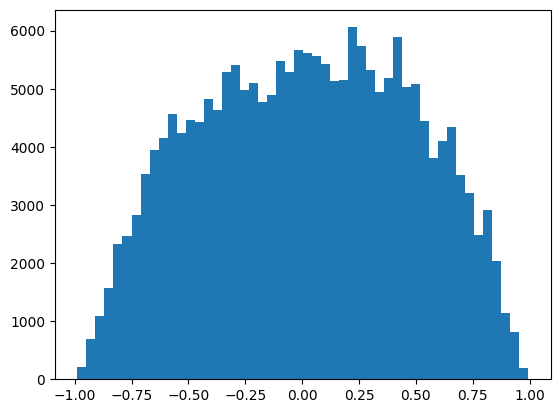

In [267]:
# https://youtu.be/P6sfmUTpUmc?si=EcT1vrXmVrLFR_Qx&t=878
# very active tanh which is stretching activations to the extremes values which killing the gradients
plt.hist(activations.view(-1).tolist(), bins=50)

(array([2.0000e+00, 6.0000e+00, 5.0000e+00, 2.1000e+01, 3.9000e+01,
        7.1000e+01, 9.2000e+01, 1.4700e+02, 3.5400e+02, 3.9800e+02,
        6.3300e+02, 1.0050e+03, 1.7540e+03, 2.4310e+03, 3.3300e+03,
        4.9320e+03, 6.9240e+03, 8.5400e+03, 9.5300e+03, 1.1093e+04,
        1.3662e+04, 1.3319e+04, 1.4977e+04, 1.5475e+04, 1.4166e+04,
        1.4695e+04, 1.2939e+04, 1.2087e+04, 9.4250e+03, 7.1240e+03,
        6.1450e+03, 4.6280e+03, 2.8460e+03, 2.6340e+03, 1.5910e+03,
        1.3460e+03, 5.2100e+02, 4.2600e+02, 2.0500e+02, 2.6000e+02,
        7.5000e+01, 4.7000e+01, 3.7000e+01, 3.7000e+01, 7.0000e+00,
        1.5000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-2.5716176 , -2.46085951, -2.35010141, -2.23934332, -2.12858522,
        -2.01782713, -1.90706903, -1.79631094, -1.68555285, -1.57479475,
        -1.46403666, -1.35327856, -1.24252047, -1.13176237, -1.02100428,
        -0.91024618, -0.79948809, -0.68872999, -0.5779719 , -0.4672138 ,
        -0.35645571, -0.24

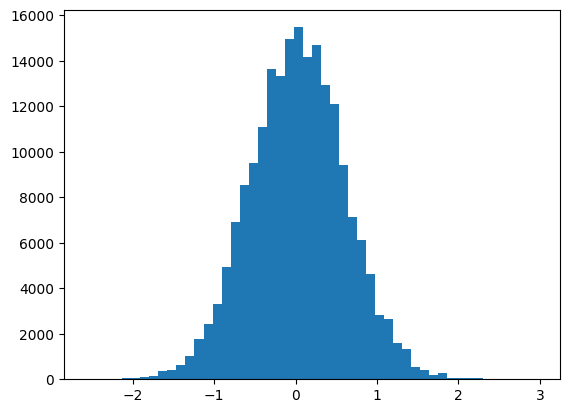

In [268]:
plt.hist(pre_activations.view(-1).tolist(), bins=50)

---

In [269]:
for p in parameters:
    p.requires_grad = True

# with torch.no_grad():
#     # https://youtu.be/P6sfmUTpUmc?si=SpZmonVTzkggqT44&t=3256
#     # calculate the mean and stardard deviation of the pre-activations for batch normalization
#     # (over the entire training set)
#     # we do this so that we can make predictions on individual examples (where mean and std are
#     # meaningless)
#     embeddings = embedding_layer[X_train]
#     pre_activations = embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights + hidden_layer_bias    
#     batch_normalization_mean = pre_activations.mean(dim=0, keepdim=True)
#     batch_normalization_st_dev = pre_activations.std(dim=0, keepdim=True)
#     print(batch_normalization_mean.shape)
#     print(batch_normalization_st_dev.shape)

In [270]:
# in practice we perform updates on minibatches of data   
losses = []

Training Loss (average): 2.835
Training Loss (average): 2.533
Training Loss (average): 2.468
Training Loss (average): 2.436
Training Loss (average): 2.397
Training Loss (average): 2.378
Training Loss (average): 2.368
Training Loss (average): 2.348
Training Loss (average): 2.345
Training Loss (average): 2.334
Training Loss (average): 2.331
Training Loss (average): 2.336
Training Loss (average): 2.309
Training Loss (average): 2.309
Training Loss (average): 2.284
Training Loss (average): 2.295
Training Loss (average): 2.293
Training Loss (average): 2.283
Training Loss (average): 2.286
Training Loss (average): 2.272
---
Validation Loss: 2.269


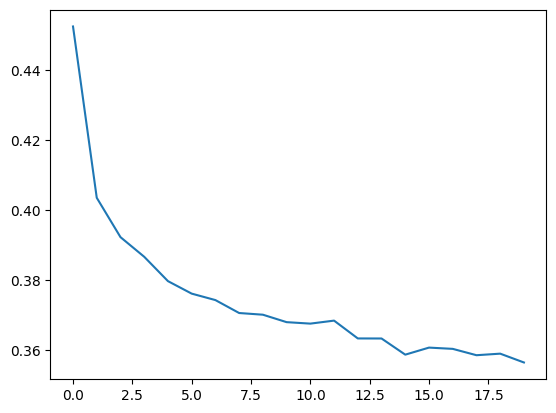

In [260]:
steps = 20000
# learning_rate = 0.1  # used in first run
learning_ratse = 0.01  # used in second run
# learning_rate = 0.001  # used in third run
batch_size = 32

sub_losses = []
for index in range(steps):
    batch_indices = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,), generator=g)
    # forward pass
    embeddings = embedding_layer[X_train[batch_indices]]
    pre_activations = embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights #+ hidden_layer_bias
    # batch normalization
    # https://youtu.be/P6sfmUTpUmc?si=9kh1cLdbp005-Df6&t=2798
    # pre_activations = batch_norm_gain \
    #     * (pre_activations - pre_activations.mean(dim=0, keepdim=True)) / pre_activations.std(dim=0, keepdim=True) \
    #     + batch_norm_bias
    # https://youtu.be/P6sfmUTpUmc?si=Z8IzPHk5C3JB4dnZ&t=3330
    batch_normalization_mean = pre_activations.mean(dim=0, keepdim=True)
    batch_normalization_st_dev = pre_activations.std(dim=0, keepdim=True)
    pre_activations = batch_norm_gain \
        * (pre_activations - batch_normalization_mean) / batch_normalization_st_dev \
        + batch_norm_bias
    # https://youtu.be/P6sfmUTpUmc?si=GzBWCdJjF00dI_eB&t=3378
    # running mean and standard deviation
    # "janky smoothing"
    with torch.no_grad():
        # we use this down below where we could make predictions on individual examples
        batch_norm_running_mean = 0.999 * batch_norm_running_mean + 0.001 * batch_normalization_mean
        batch_norm_running_st_dev = 0.999 * batch_norm_running_st_dev + 0.001 * batch_normalization_st_dev
    # end batch normalization

    activations = torch.tanh(pre_activations)
    logits = activations @ output_layer_weights + output_layer_bias
    loss = F.cross_entropy(logits, Y_train[batch_indices])
    # losses.append(loss.item())
    sub_losses.append(loss.item())
    if (index + 1) % (steps / 20) == 0:
        average_loss = sum(sub_losses) / len(sub_losses)
        losses.append(average_loss)
        sub_losses = []
        print(f"Training Loss (average): {average_loss:.3f}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

print('---')

with torch.no_grad():
    # loss on VALIDATION set; the model has not seen this data
    embeddings = embedding_layer[X_val]
    pre_activations = embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights #+ hidden_layer_bias
    pre_activations = batch_norm_gain \
            * (pre_activations - batch_norm_running_mean) / batch_norm_running_st_dev \
            + batch_norm_bias
    activations = torch.tanh(pre_activations)
    logits = activations @ output_layer_weights + output_layer_bias
    loss = F.cross_entropy(logits, Y_val)
    print(f"Validation Loss: {loss:.3f}")

plt.plot([math.log10(x) for x in losses])
plt.show()
plot_embeddings()

In [261]:
plot_embeddings()

---

# Generate predictions from the model

In [ ]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * context_length # initialize with all ... (which is index 0)
    while True:
        embeddings = embedding_layer[torch.tensor([context])] # (1,block_size,d)
        pre_activations = embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights #+ hidden_layer_bias
        pre_activations = batch_norm_gain \
            * (pre_activations - batch_norm_running_mean) / batch_norm_running_st_dev \
            + batch_norm_bias
        activations = torch.tanh(pre_activations)
        logits = activations @ output_layer_weights + output_layer_bias
        probs = F.softmax(logits, dim=1)
        # pull random sample from the model's probability distribution
        token_index = torch.multinomial(probs, num_samples=1, generator=None).item()
        context = context[1:] + [token_index]
        out.append(token_index)
        if token_index == 0:
            break
    print(''.join(index_to_character[i] for i in out))

tajanastrrton.
rurhaynn.
osni.
raima.
kayser.
euti.
pnperh.
samanidrah.
kins.
brkarfyyine.
yavone.
loig.
olah.
min.
noa.
reya.
aj.
marmsra.
tardian.
nyn.


---

# Part 3.2 - Pytorch-ifying Code

In [ ]:
# at the start our loss was very high, much higher than what we would expect
# If we have 27 characters, then we would expect a uniform distribution as
# our best guess for the next character, which would give us a loss of -ln(1/27)
# but our loss was much higher than that (e.g. 27)
-torch.tensor(1/27).log()

In [488]:
g = torch.Generator().manual_seed(2147483647)
context_length = 3  # how many characters do we take to predict the next one?

X, Y = [], []

for word in words:
    word = ('.' * context_length) + word + '.'
    for i in range(len(word) - context_length):
        X.append([token_mappings[c] for c in word[i:i+context_length]])
        Y.append(token_mappings[word[i+context_length]])


for x, y in zip(X[:10], Y[:10]):
    print(f"{x} -> {y}")
    print(f"{''.join([index_to_character[i] for i in x])} -> {index_to_character[y]}")
    print('---')

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

# Shuffle the data
indices = torch.randperm(X.size(0), generator=g)
assert len(set(indices)) == X.size(0)
X = X[indices]
Y = Y[indices]

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split sizes
total_size = X.size(0)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Split the tensors
X_train, X_val, X_test = torch.split(X, [train_size, val_size, test_size])
Y_train, Y_val, Y_test = torch.split(Y, [train_size, val_size, test_size])

# Printing the shapes of the datasets
print("Training set shapes:")
print(X_train.shape)
print(Y_train.shape)
print("Validation set shapes:")
print(X_val.shape)
print(Y_val.shape)
print("Test set shapes:")
print(X_test.shape)
print(Y_test.shape)

[0, 0, 0] -> 5
... -> e
---
[0, 0, 5] -> 13
..e -> m
---
[0, 5, 13] -> 13
.em -> m
---
[5, 13, 13] -> 1
emm -> a
---
[13, 13, 1] -> 0
mma -> .
---
[0, 0, 0] -> 15
... -> o
---
[0, 0, 15] -> 12
..o -> l
---
[0, 15, 12] -> 9
.ol -> i
---
[15, 12, 9] -> 22
oli -> v
---
[12, 9, 22] -> 9
liv -> i
---
torch.Size([228146, 3])
torch.Size([228146])
Training set shapes:
torch.Size([182516, 3])
torch.Size([182516])
Validation set shapes:
torch.Size([22814, 3])
torch.Size([22814])
Test set shapes:
torch.Size([22816, 3])
torch.Size([22816])


In [489]:
# https://youtu.be/P6sfmUTpUmc?si=hKQg9w2hfxwsVfgD&t=4715

from sklearn.decomposition import PCA
import plotly_express as px
    

class Linear:
    """Linear layer of a neural network."""

    def __init__(
            self,
            in_features: int,
            out_features: int,
            bias: bool = True,
            requires_grad: bool = True,
            generator: object = None,
            ) -> None:
        self.in_features = in_features
        self.out_features = out_features
        self.weights = torch.randn(
            (in_features, out_features),
            generator=generator
        )
        self.weights /= in_features**0.5
        self.weights.requires_grad = requires_grad
        self.bias = torch.zeros(out_features, requires_grad=True) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.bias is not None:
            self.out = x @ self.weights + self.bias
        else:
            self.out = x @ self.weights
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return [self.weights] + ([self.bias] if self.bias is not None else [])


class EmbeddingLayer(Linear):
    """Embedding layer of a neural network."""
# embedding_layer = torch.randn(len(characters), embedding_dimension, generator=g)
    def __init__(
            self,
            num_tokens: int,
            num_embeddings: int,
            context_length: int,
            bias: bool = False,
            requires_grad: bool = True,
            generator: object = None,
            ) -> None:
        super().__init__(
            in_features=num_tokens,
            out_features=num_embeddings,
            bias=bias,
            requires_grad=requires_grad,
            generator=generator,
        )
        self.context_length = context_length
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = self.weights[x].view(-1, self.context_length * self.out_features)
        return self.out

    # ONLY VISUALIZING THE FIRST TWO DIMENSIONS OF THE EMBEDDING
    # MAY NOT BE THE BEST WAY TO VISUALIZE THE EMBEDDINGS FOR EMBEDDING_DIMENSION > 2
    def plot_embeddings(self):
        _embedding_layer = self.weights.detach().numpy()
        if _embedding_layer.shape[1] > 2:
            if _embedding_layer.shape[1] > 3:
                print("Warning: Embedding dimension greater than 3. Running PCA to extract first three dimensions.")   
                pca = PCA(n_components=4)
                _embedding_layer = pca.fit_transform(_embedding_layer)
            fig = px.scatter_3d(
                    x=_embedding_layer[:,0].data,
                    y=_embedding_layer[:,1].data,
                    z=_embedding_layer[:,2].data,
                    color=embedding_layer[:,3].data,
                    labels={'x': 'C-1', 'y': 'C-2', 'z': 'C-3', 'color': 'C-4'},
                    text=index_to_character,
                    # color=index_to_character,
                    height=1000,
                    width=1000,
                )
        else:
            fig = px.scatter(
                x=_embedding_layer[:,0].data,
                y=_embedding_layer[:,1].data,
                text=index_to_character,
                # color=index_to_character,
                height=800,
                width=800,
            )
            fig.update_traces(textposition='top center')
        return fig


class BatchNorm1D:
    """
    Batch normalization layer of a neural network.
    
    Basic implementation of https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
    """

    def __init__(self, dim: tuple[int, int], eps=1e-5, momentum=0.1, requires_grad: bool=True) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with back-propagation)
        self.gain = torch.ones(dim, requires_grad=True)  # γ (gamma) in the url
        self.bias = torch.zeros(dim, requires_grad=True)  # β (beta) in the url
        # buffers (trained with a running 'momentum update' of the mean and standard deviation)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # when training, we calculate the mean and standard deviation of the current batch
            x_mean = x.mean(dim=0, keepdim=True)
            x_var = x.var(dim=0, keepdim=True)
        else:
            # when evaluating, we use the running mean and standard deviation
            x_mean = self.running_mean
            x_var = self.running_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)  # normalize to unit variance
        self.out = self.gain * x_hat + self.bias  # scale and shift
        if self.training:
            with torch.no_grad():
                # these are not parameters of the model; they are used to normalize the activations
                # when we make predictions (e.g on individual examples)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [self.gain, self.bias]
    
class Tanh:
    """Tanh activation function."""

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x.tanh()
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return []

class NeuralNetwork:
    """Neural network."""

    def __init__(self, layers: list, generator: object | None = None) -> None:
        self.layers = layers
        self.generator = generator
        self.training_losses = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x
    
    def loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        logits = self.forward(x)
        return F.cross_entropy(logits, y)
    
    def zero_grad(self) -> None:
        for p in self.parameters():
            p.grad = None

    def train(
            self,
            x: torch.Tensor,
            y: torch.Tensor,
            learning_rate: float,
            steps: int = 20000,
            batch_size: int = 32,
            ) -> float:
        losses = []
        sub_losses = []
        for index in range(steps):
            batch_indices = torch.randint(low=0, high=x.shape[0], size=(batch_size,), generator=self.generator)
            x_batch, y_batch = x[batch_indices], y[batch_indices]
            # forward pass
            loss = self.loss(x=x_batch, y=y_batch)
            # backward pass
            self.zero_grad()
            loss.backward()
            # update parameters
            for p in self.parameters():
                p.data -= learning_rate * p.grad
            sub_losses.append(loss.item())
            if index % (steps / 20) == 0 or index == steps - 1:
                average_loss = sum(sub_losses) / len(sub_losses)
                losses.append(average_loss)
                sub_losses = []
                print(f"Training Loss (average): {average_loss:.3f}")
        self.training_losses += losses
        return losses

    def parameters(self) -> list[torch.Tensor]:
        return [p for layer in self.layers for p in layer.parameters()]
    
    def plot_training_losses(self):
        plt.plot([math.log10(x) for x in self.training_losses])
        plt.show()

In [491]:
g = torch.Generator().manual_seed(2147483647)

embedding_dimension = 10
# context_length = 3  # defined when creating the dataset
num_neurons = 100

# original code
# embedding_layer = torch.randn(len(characters), embedding_dimension, generator=g)
# hidden_layer_weights = 0.1 * torch.randn(context_length * embedding_dimension, num_neurons, generator=g)
# output_layer_weights = 0.1 * torch.randn(num_neurons, len(characters), generator=g)
# output_layer_bias = torch.zeros(len(characters))
# batch_norm_gain = torch.ones((1, num_neurons))
# batch_norm_bias = torch.zeros((1, num_neurons))

layers = [
    EmbeddingLayer(
        num_tokens=len(characters),
        num_embeddings=embedding_dimension,
        context_length=context_length,
        generator=g,
    ),
    Linear(in_features=context_length * embedding_dimension, out_features=num_neurons, generator=g),
    Tanh(),
    Linear(in_features=num_neurons, out_features=num_neurons, generator=g),
    Tanh(),
    Linear(in_features=num_neurons, out_features=num_neurons, generator=g),
    Tanh(),
    Linear(in_features=num_neurons, out_features=num_neurons, generator=g),
    Tanh(),
    Linear(in_features=num_neurons, out_features=num_neurons, generator=g),
    Tanh(),
    Linear(in_features=num_neurons, out_features=len(characters), generator=g),
]

model = NeuralNetwork(layers)
print(f"Number of Parameters of Model: {sum(p.nelement() for p in model.parameters()):,}")

Number of Parameters of Model: 46,497


In [492]:
layers[0].plot_embeddings()

Layer 0: mean=-0.011, std=0.185, saturated=0.00%
Layer 1: mean=-0.003, std=0.175, saturated=0.00%
Layer 2: mean=0.003, std=0.174, saturated=0.00%
Layer 3: mean=0.002, std=0.163, saturated=0.00%
Layer 4: mean=-0.007, std=0.161, saturated=0.00%


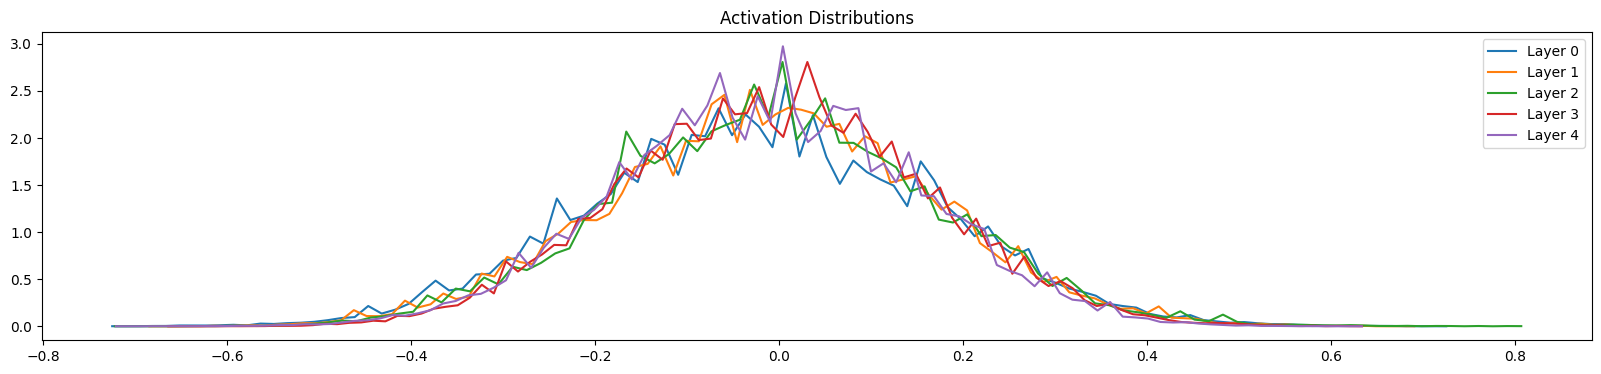

In [493]:
# single step
loss = model.loss(X_train, Y_train)

plt.figure(figsize=(20, 4))
legends = []
for index, layer in enumerate([layer for layer in model.layers if isinstance(layer, Tanh)]):
    t = layer.out
    print(f"Layer {index}: mean={t.mean():.3f}, std={t.std():.3f}, saturated={(t.abs() > 0.97).float().mean()*100:.2f}%")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Layer {index}")
plt.legend(legends)
plt.title("Activation Distributions")
plt.show()

Layer 0: mean=0.000, std=0.000
Layer 1: mean=-0.000, std=0.000
Layer 2: mean=0.000, std=0.000
Layer 3: mean=0.000, std=0.000
Layer 4: mean=-0.000, std=0.000


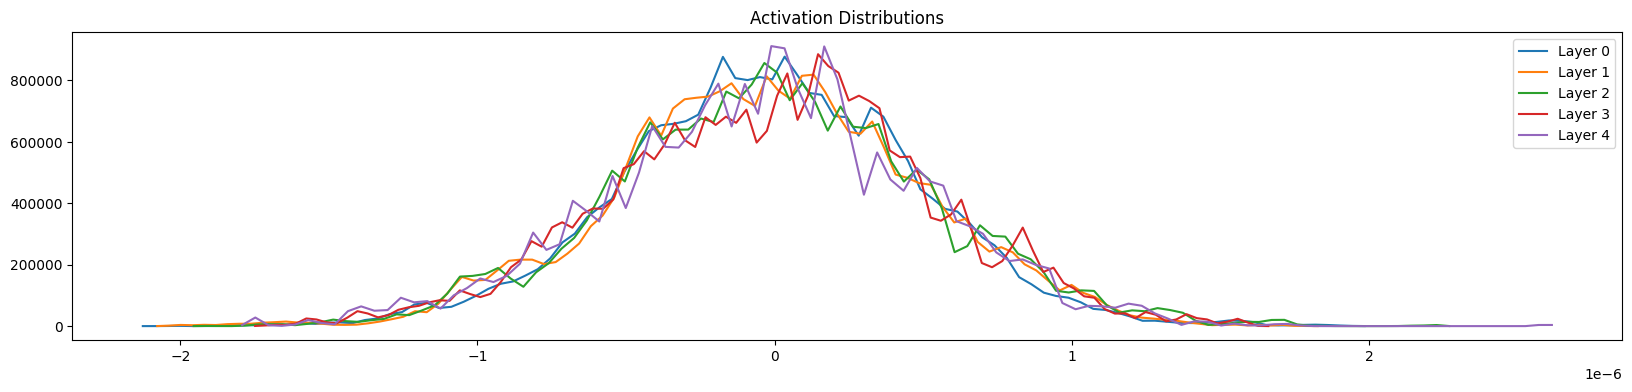

In [494]:
for layer in model.layers:
    layer.out.retain_grad()
model.zero_grad()
loss.backward()

plt.figure(figsize=(20, 4))
legends = []
for index, layer in enumerate([layer for layer in model.layers if isinstance(layer, Tanh)]):
    t = layer.out.grad
    print(f"Layer {index}: mean={t.mean():.3f}, std={t.std():.3f}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Layer {index}")
plt.legend(legends)
plt.title("Activation Distributions")
plt.show()

In [495]:
print(f"{t.std():.10f}")

0.0000005301


In [496]:
losses = model.train(x=X_train, y=Y_train, learning_rate=0.1)
# model.train(x=X_train, y=Y_train, learning_rate=0.01)
# model.train(x=X_train, y=Y_train, learning_rate=0.001)

Training Loss (average): 3.289


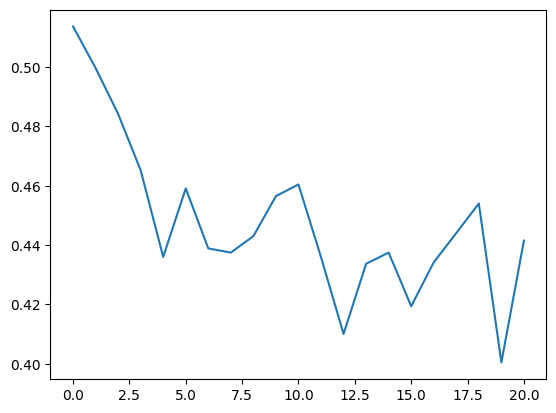

In [ ]:
model.plot_training_losses()

In [ ]:
layers[0].plot_embeddings()

In [251]:
steps = 20000
# learning_rate = 0.1  # used in first run
learning_rate = 0.01  # used in second run
# learning_rate = 0.001  # used in third run
batch_size = 32

sub_losses = []
for index in range(steps):
    batch_indices = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,), generator=g)
    # forward pass
    embeddings = embedding_layer[X_train[batch_indices]] # for each example, gets the x embeddings for each character in the context
    pre_activations = embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights #+ hidden_layer_bias
    # batch normalization
    # https://youtu.be/P6sfmUTpUmc?si=9kh1cLdbp005-Df6&t=2798
    # pre_activations = batch_norm_gain \
    #     * (pre_activations - pre_activations.mean(dim=0, keepdim=True)) / pre_activations.std(dim=0, keepdim=True) \
    #     + batch_norm_bias
    # https://youtu.be/P6sfmUTpUmc?si=Z8IzPHk5C3JB4dnZ&t=3330
    batch_normalization_mean = pre_activations.mean(dim=0, keepdim=True)
    batch_normalization_st_dev = pre_activations.std(dim=0, keepdim=True)
    pre_activations = batch_norm_gain \
        * (pre_activations - batch_normalization_mean) / batch_normalization_st_dev \
        + batch_norm_bias
    # https://youtu.be/P6sfmUTpUmc?si=GzBWCdJjF00dI_eB&t=3378
    # running mean and standard deviation
    # "janky smoothing"
    with torch.no_grad():
        # we use this down below where we could make predictions on individual examples
        batch_norm_running_mean = 0.999 * batch_norm_running_mean + 0.001 * batch_normalization_mean
        batch_norm_running_st_dev = 0.999 * batch_norm_running_st_dev + 0.001 * batch_normalization_st_dev
    # end batch normalization

    activations = torch.tanh(pre_activations)
    logits = activations @ output_layer_weights + output_layer_bias
    loss = F.cross_entropy(logits, Y_train[batch_indices])
    # losses.append(loss.item())
    sub_losses.append(loss.item())
    if (index + 1) % (steps / 20) == 0:
        average_loss = sum(sub_losses) / len(sub_losses)
        losses.append(average_loss)
        sub_losses = []
        print(f"Training Loss (average): {average_loss:.3f}")

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

print('---')

with torch.no_grad():
    # loss on VALIDATION set; the model has not seen this data
    embeddings = embedding_layer[X_val]
    pre_activations = embeddings.view(-1, context_length * embedding_dimension) @ hidden_layer_weights #+ hidden_layer_bias
    pre_activations = batch_norm_gain \
            * (pre_activations - batch_norm_running_mean) / batch_norm_running_st_dev \
            + batch_norm_bias
    activations = torch.tanh(pre_activations)
    logits = activations @ output_layer_weights + output_layer_bias
    loss = F.cross_entropy(logits, Y_val)
    print(f"Validation Loss: {loss:.3f}")

plt.plot([math.log10(x) for x in losses])
plt.show()
plot_embeddings()

RuntimeError: shape '[-1, 30]' is invalid for input of size 192